**EE4685 Assignment 2: Building a miniGPT** by Josephine King and Alec Daalman

**References:**
- "Let's build GPT: from scratch, in code, spelled out." Youtube tutorial by Andrej Karpathy. https://www.youtube.com/watch?v=kCc8FmEb1nY
- HuggingFace Tokenizer developer guides. https://huggingface.co/docs/transformers/en/notebooks


In [622]:
# Import packages
import os
import json
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
from tokenizers import Tokenizer, pre_tokenizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

run_on_colab = False

# Setup
torch.manual_seed(6250513)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# Set up file saving on google drive
if (run_on_colab):
    from google.colab import drive
    drive.mount('/content/drive')
    # Create a folder in the root directory
    !mkdir -p "./drive/MyDrive/saved_models"
    CHECKPOINT_PATH = "./drive/MyDrive/saved_models/"
else:
    CHECKPOINT_PATH = "./saved_models/"

# Initialize model parameters
TRAIN_PCT = 0.8
VOCAB_SIZE = 10000
LR = 2.5e-4

# Download the TinyShakespeare dataset
!wget -O tinyshakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f: raw_data = f.read()


Using device cpu
--2025-03-26 16:22:43--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tinyshakespeare.txt’

tinyshakespeare.txt   0%[                    ]       0  --.-KB/s               

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tinyshakespeare.txt 100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2025-03-26 16:22:43 (8.74 MB/s) - ‘tinyshakespeare.txt’ saved [1115394/1115394]



**GPT Model:**

In [696]:
# GPT architecture 
class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, batch_size, embd_dim, decoders, num_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embd_dim)
        self.position_embedding_table = nn.Embedding(block_size, embd_dim)

        self.transformer_blocks = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=embd_dim, nhead=num_heads, dim_feedforward=3072, dropout=0.1), decoders, norm=None)
        self.linear_layer = nn.Linear(embd_dim, vocab_size)
        self.block_size = block_size

        self.config = {"vocab_size": vocab_size, "block_size": block_size, "batch_size": batch_size, "embd_dim": embd_dim, "decoders": decoders, "num_heads": num_heads}

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        inputs = tok_emb + pos_emb # (B,T,C)
        inputs = self.transformer_blocks(inputs, memory=torch.zeros_like(inputs))
        logits = self.linear_layer(inputs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # Generate num_gen_tokens more tokens given the current tokens in curr_tokens
    def generate(self, curr_tokens, num_gen_tokens):
        for _ in range(num_gen_tokens):
            curr_tokens_cond = curr_tokens[:, -self.block_size:]
            print(curr_tokens_cond)
            # Get the predictions for the next tokens 
            preds, loss = self(curr_tokens_cond)
            # Look only at the last time step
            preds = preds[:, -1, :] # becomes (B, C)
            # Normalize probabilities from 0 to 1 using softmax
            probs = F.softmax(preds, dim=-1) # (B, C)
            # Get the next token by sampling from the probability distribution
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Add the new token to the current tokens
            curr_tokens = torch.cat((curr_tokens, next_token), dim=1) # (B, T+1)
        return curr_tokens

**Model Helper Functions:**

In [ ]:
def get_batch(data, batch_size, block_size):
    # Choose batch_size random starting points
    block_starts = torch.randint(0, len(data) - block_size, (batch_size,))
    # Get the inputs and outputs for the chosen blocks, stack them into tensors
    batch_inputs = torch.stack([data[start: start + block_size] for start in block_starts])
    batch_outputs = torch.stack([data[start + 1: start + block_size + 1] for start in block_starts])
    return batch_inputs, batch_outputs

def estimate_loss(model, data, batch_size, block_size, iters):
    out = {}
    model.eval()
    losses = torch.zeros(iters)
    for k in range(iters):
        inputs, outputs = get_batch(data, batch_size, block_size)
        with torch.no_grad():
            logits, loss = model(inputs, outputs)
        losses[k] = loss.item()
    mean_loss = losses.mean()
    model.train()
    return mean_loss

**Model Training Functions:**

In [ ]:
# The following functions are adapted from the optimization exercise 
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def save_model(model, model_path, model_name, model_result, results_only):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file, result_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name), _get_result_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    with open(result_file, "w") as f:
        json.dump(model_result, f)
    if (results_only == False):
        torch.save(model.state_dict(), model_file)

def load_model(model_path, model_name):
    config_file, model_file, result_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name), _get_result_file(model_path, model_name)
    with open(config_file, "r") as f:
        config_dict = json.load(f)

    model = GPT(config_dict["vocab_size"], config_dict["block_size"], config_dict["batch_size"], config_dict["embd_dim"], config_dict["decoders"], config_dict["num_heads"])
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))    
    
    with open(result_file, "r") as f:
        model_result = json.load(f)

    return model, model_result

def train_model(train_set, validation_set, model, model_name, optimizer, max_iter=1000, batch_size=256, block_size=32, overwrite=False, savemodel=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        train_set - Training dataset
        validation_set - Validation dataset
        model - nn.Module object
        model_name - Name of the model
        max_iter - Number of iterations we want to (maximally) train for
        batch_size - Size of batches used in training
        overwrite - Determines if we should overwrite pre-existing models
        savemodel - Whether or not we should save the model to a file
    """
    # Check if the model already exists
    # If it does and we are not overwriting, load it from the file
    # If it doesn't, train the model
    file_exists = os.path.isfile(_get_config_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        model, results = load_model(CHECKPOINT_PATH, model_name)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Training the model
        training_losses = []
        validation_losses = []
        iters = []
        iter_times = []
        results = {}
        best_loss = 1000
        model.train()
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iter)
        
        for iter in range(max_iter):
            start_time = time.time()
            inputs, outputs = get_batch(train_set, batch_size, block_size)
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            preds,loss = model(inputs, outputs)
            iter_times.append(time.time() - start_time)

            # Printing 
            if iter % 50 == 0 or iter == max_iter - 1:
                print(f"iter {iter}: loss = {loss}")

            # Estimate and save the training loss and validation loss
            if (iter % 50 == 0):
                training_loss = estimate_loss(model, train_set, batch_size, block_size, 100)
                validation_loss = estimate_loss(model, validation_set, batch_size, block_size, 100)
                training_losses.append(training_loss.item())
                validation_losses.append(validation_loss.item())
                iters.append(iter)
                if (loss < best_loss and savemodel == True):
                    print("Best loss so far, saving model")
                    # Calculate the perplexity and save results to the dict
                    perplexity = np.exp(validation_loss.item())
                    results["perplexity"] = perplexity
                    results["total_params"] = sum(p.numel() for p in model.parameters())
                    results["iters"] = iters
                    results["training_loss"] = training_losses
                    results["validation_loss"] = validation_losses
                    results["avg_time_per_iter"] = np.mean(iter_times)
                    # Save the model to a file
                    save_model(model, CHECKPOINT_PATH, model_name, results, False)
                    best_loss = loss

            loss.backward()
            optimizer.step()
            scheduler.step()
    
        results["iters"] = iters
        results["training_loss"] = training_losses
        results["validation_loss"] = validation_losses
        results["avg_time_per_iter"] = np.mean(iter_times)
        save_model(model, CHECKPOINT_PATH, model_name, results, True)

    torch.cuda.empty_cache()
    return model, results

**Data Preprocessing**

Create a custom tokenizer using the HuggingFace Tokenizer package. Then encode the data, convert it into a PyTorch tensor, and split it up into validation data and training data.

In [632]:
# Create the tokenizer 
def train_tokenizer(train_file_name, save_file_name, vocab_size):
    print("Training tokenizer")
    train_file_name = train_file_name + ".txt"
    tokenizer = Tokenizer(BPE(unk_token="[UNK]")) 
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence([pre_tokenizers.Punctuation("isolated"), pre_tokenizers.Split("\n", "isolated"), pre_tokenizers.Split(" ", "isolated")])
    trainer = BpeTrainer(vocab_size=vocab_size)
    tokenizer.decoder = BPEDecoder()
    tokenizer.train([train_file_name], trainer)
    tokenizer.save(save_file_name)
    return tokenizer

# Load a pre-existing tokenizer
def load_tokenizer(file_name):
    print("Loading tokenizer from file")
    tokenizer = Tokenizer.from_file(file_name)
    return tokenizer

def get_tokenizer(train_file_name, vocab_size, overwrite = False):
    file_name = train_file_name + "_" + str(vocab_size) + ".json"
    if (overwrite == False):
        tokenizer = load_tokenizer(file_name)
    else:
        tokenizer = train_tokenizer(train_file_name, file_name, vocab_size)
    return tokenizer

# Tokenize the data
def tokenize_data(tokenizer, raw_data, train_pct):
    tokenized_data = tokenizer.encode(raw_data).ids
    # Convert into a pytorch tensor
    tensor_data = torch.tensor(tokenized_data, dtype=torch.long)
    # Split into training and validation sets
    train_end = int(len(tensor_data)*train_pct)
    training_data = tensor_data[:train_end]
    validation_data = tensor_data[train_end:]
    return training_data, validation_data

tokenizer = get_tokenizer("tinyshakespeare", VOCAB_SIZE, False)
training_data, validation_data = tokenize_data(tokenizer, raw_data, TRAIN_PCT)

Loading tokenizer from file


**Perform a grid search to find the best parameters:**

Training model gpt_model_1500_32_32_192_1000_1_12
Model file of "gpt_model_1500_32_32_192_1000_1_12" already exists. Skipping training...
Training model gpt_model_1500_32_32_192_1000_2_12
Model file of "gpt_model_1500_32_32_192_1000_2_12" already exists. Skipping training...
Training model gpt_model_1500_32_32_192_1000_3_12
Model file of "gpt_model_1500_32_32_192_1000_3_12" already exists. Skipping training...


/var/folders/ql/c3sy06152ddb023_v8jtctww0000gn/T/ipykernel_12946/3009254521.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/ql/c3sy06152ddb023_v8jtctww0000gn/T/ipykernel_12946/3009254521.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


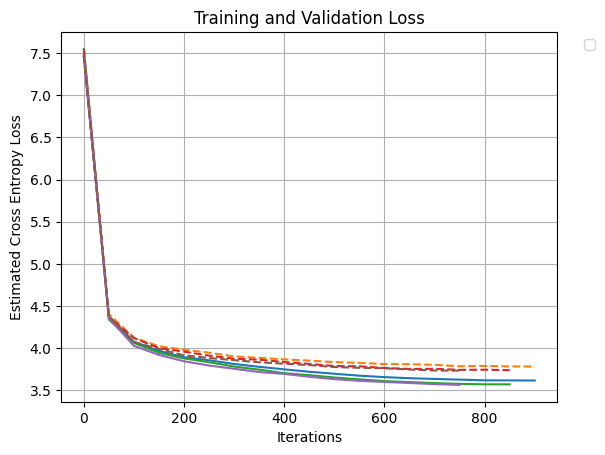

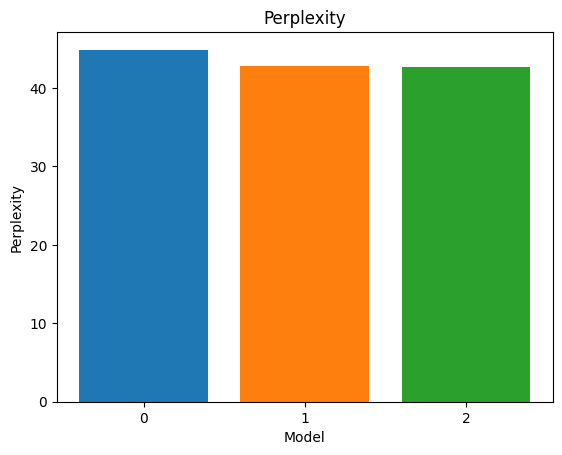

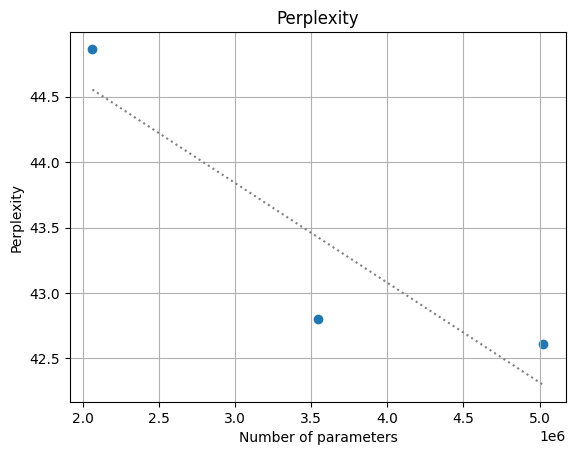

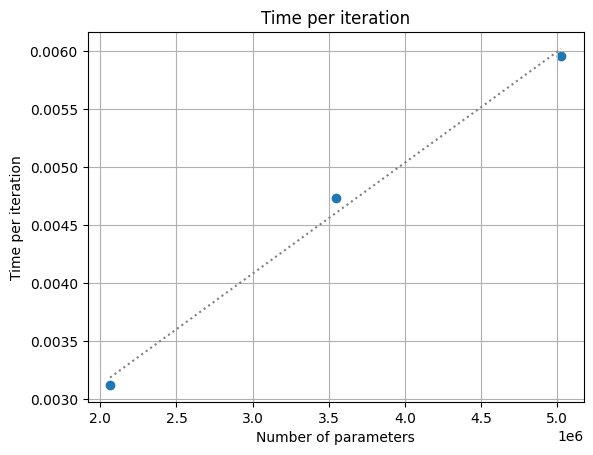

In [618]:
loop_decoders = True
loop_embd_dims = False
loop_blocks = False

block_sizes = [32]
batch_sizes = [32]
max_iters = [1000]
embd_dims = [192]
num_decoders = [1]
num_heads = [12]

if (loop_decoders == True):
    num_decoders = [1, 2, 3]
if (loop_embd_dims == True):
    embd_dims = [192, 384]
if (loop_blocks == True):
    block_sizes = [32, 64, 128]

# Set up plotting
plt.ion()
fig, ax = plt.subplots()
ax.set_xlabel("Iterations")
ax.set_ylabel("Estimated Cross Entropy Loss")
ax.set_title("Training and Validation Loss")
ax.grid(True)

fig2, ax2 = plt.subplots()
ax2.set_xlabel("Model")
ax2.set_ylabel("Perplexity")
ax2.set_title("Perplexity")

total_params = []
perplexity = []
time_per_iter = []

# Loop through parameters and train model 
iter = 0
for block_size in block_sizes:
    for batch_size in batch_sizes:
        for max_iter in max_iters:
            for embd_dim in embd_dims:
                for num_decoder in num_decoders:
                    for num_head in num_heads:
                        # Train the model
                        model_name = f"gpt_model_{VOCAB_SIZE}_{block_size}_{batch_size}_{embd_dim}_{max_iter}_{num_decoder}_{num_head}"
                        print(f"Training model {model_name}")
                        gpt_model = GPT(VOCAB_SIZE, block_size, batch_size, embd_dim, num_decoder, num_head).to(device)
                        optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=LR)
                        gpt_model, gpt_results = train_model(
                            training_data.to(device), validation_data.to(device), gpt_model, model_name, optimizer, 
                            max_iter=max_iter, batch_size=batch_size, block_size=block_size, overwrite=False, savemodel=True 
                        )
                        # Plotting
                        ax.plot(gpt_results["iters"], gpt_results["training_loss"], linestyle="-")
                        ax.plot(gpt_results["iters"], gpt_results["validation_loss"], linestyle="--")
                        
                        ax2.bar(f"{iter}", gpt_results["perplexity"])

                        total_params.append(gpt_results["total_params"])
                        perplexity.append(gpt_results["perplexity"])
                        time_per_iter.append(gpt_results["avg_time_per_iter"])
                        iter += 1

ax.legend()
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

fig3, ax3 = plt.subplots()
ax3.set_xlabel("Number of parameters")
ax3.set_ylabel("Perplexity")
ax3.set_title("Perplexity")
ax3.grid(True)
ax3.scatter(total_params, perplexity)
trendline = np.polyfit(total_params, perplexity, 1)
p = np.poly1d(trendline)
ax3.plot(total_params,p(total_params),color="gray",linestyle="dotted")

fig4, ax4 = plt.subplots()
ax4.set_xlabel("Number of parameters")
ax4.set_ylabel("Time per iteration")
ax4.set_title("Time per iteration")
ax4.grid(True)
ax4.scatter(total_params, time_per_iter)
trendline = np.polyfit(total_params, time_per_iter, 1)
p = np.poly1d(trendline)
ax4.plot(total_params,p(total_params),color="gray",linestyle="dotted")


**Generate text with the model:**

In [ ]:
vocab_size = VOCAB_SIZE
block_size = 128
batch_size = 32
embd_dim = 192
max_iter = 1000
num_decoders = 1
num_heads = 12

model_name = f"gpt_model_{vocab_size}_{block_size}_{batch_size}_{embd_dim}_{max_iter}_{num_decoders}_{num_heads}"
gpt_model = GPT(vocab_size, block_size, batch_size, embd_dim, num_decoders, num_heads).to(device)
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=LR)
gpt_model, gpt_results = train_model(
    training_data.to(device), validation_data.to(device), gpt_model.to(device), model_name, optimizer, 
    max_iter=max_iter, batch_size=batch_size, block_size=block_size, overwrite=False, savemodel=True 
)

starting_text = " "
starting_tokens = tokenizer.encode(starting_text).ids
starting_tokens = torch.tensor(starting_tokens, dtype=torch.long).reshape(-1,1)
starting_tokens = torch.zeros((1, 1), dtype=torch.long, device=device)
#starting_tokens = get_batch(validation_data, 1, block_size)[0].reshape(-1,1)
print(starting_tokens)
gen_tokens = gpt_model.generate(curr_tokens = starting_tokens.to(device), num_gen_tokens = 200)[0, 1:].tolist()

print("-------------------------------------")
print("GPT model")
print("-------------------------------------")
print(f"Model parameters: {gpt_results["total_params"]}")
#print(f"Average time per iteration: {gpt_results["avg_time_per_iter"]}")
print(gpt_results["training_loss"])
print(gpt_results["validation_loss"])

print(f"Perplexity: {gpt_results["perplexity"]}")
print(tokenizer.decode(gen_tokens))

Model file of "gpt_model_10000_128_32_192_1000_1_12" already exists. Skipping training...
tensor([[1]])
tensor([[1]])
tensor([[1, 1]])
tensor([[1, 1, 1]])
tensor([[1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1]])
tensor([[ 1,  1,  1,  1,  1, 80]])
tensor([[ 1,  1,  1,  1,  1, 80,  1]])
tensor([[ 1,  1,  1,  1,  1, 80,  1,  1]])
tensor([[ 1,  1,  1,  1,  1, 80,  1,  1, 10]])
tensor([[ 1,  1,  1,  1,  1, 80,  1,  1, 10,  6]])
tensor([[ 1,  1,  1,  1,  1, 80,  1,  1, 10,  6,  1]])
tensor([[ 1,  1,  1,  1,  1, 80,  1,  1, 10,  6,  1,  1]])
tensor([[ 1,  1,  1,  1,  1, 80,  1,  1, 10,  6,  1,  1,  0]])
tensor([[  1,   1,   1,   1,   1,  80,   1,   1,  10,   6,   1,   1,   0, 591]])
tensor([[  1,   1,   1,   1,   1,  80,   1,   1,  10,   6,   1,   1,   0, 591,
           5]])
tensor([[  1,   1,   1,   1,   1,  80,   1,   1,  10,   6,   1,   1,   0, 591,
           5, 342]])
tensor([[  1,   1,   1,   1,   1,  80,   1,   1,  10,   6,   1,   1,   0, 591,
           5, 342,   1]])
tensor([[  1,   1,   1,